Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


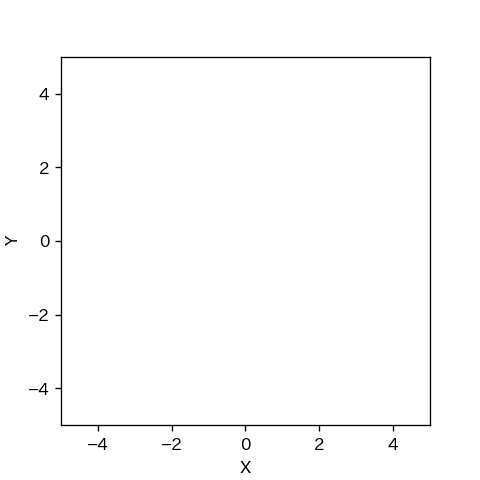

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


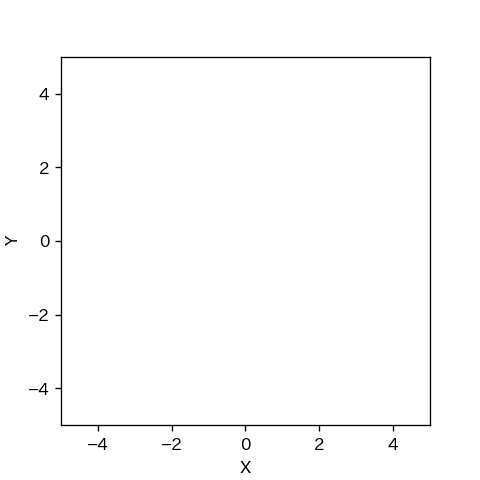

(array([ 2.91144032, -2.30048971,  1.60909473]),
 array([-0.05743226, -3.26110504,  2.1254649 ]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[7.060516754020141]
[3.825480845179792, 6.199666216674589]
[3.1743352889962284, 5.778429019124716]
[3.108938530215332, 5.494464929288656]
[3.793481767699822, 5.936010633446914]
0 真値: [-4.05325801  0.49880523  4.30333071] 推定値: [-4.05853726  0.15400436  4.21645116] 誤差: 0.34484128651310003
1
[7.118111161402434]
1 真値: [3.62810938 2.20989893 7.44197947] 推定値: [-2.83187274 -7.32911023  3.45987182] 誤差: 11.520593071665486
[1.8485160056391026]
2 真値: [-2.72304568 -2.11394611  7.19391381] 推定値: [-3.38664251 -1.17330777  7.1520193 ] 誤差: 1.1511564801368217
[4.55887069032815]
3 真値: [ 4.73056987 -1.86087479  7.72323597] 推定値: [ 4.60967795 -1.88721878  7.63417219] 誤差: 0.12372899032289898
2
[2.614432693671155]
4 真値: [ 1.45493346 -3.20087362  2.57057539] 推定値: [ 2.46101428 -3.33944144 -1.7894651 ] 誤差: 1.0155784878012037
[4.637690481439242]
5 真値: [-4.50721395 -2.19551584  7.33274402] 推定値: [ 0.74876426 -0.59292652  8.47274078] 誤差: 5.494870283456484
[3.27068330303339]
6 真値: [5.14350348 0.24315057 3.9530595 ] 推

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.474626045693626]
20 真値: [-1.25890076 -4.63910225  7.79264471] 推定値: [-2.35773577 -3.9421969   7.50464393] 誤差: 1.3011976949435238
[3.8743730759140504]
21 真値: [-0.54401864 -2.18123167  2.22320149] 推定値: [-0.47469452 -2.72080507  2.07842486] 誤差: 0.5440085380999714
10
[3.2348761822207805, 4.933743826739577]
22 真値: [0.07277874 1.01337674 2.23863286] 推定値: [-0.29358298  0.98630709  2.18390576] 誤差: 0.36736040975067996
11
[4.33304846223911, 5.4395438736861195]
23 真値: [-1.7156865   3.02749178  3.31950544] 推定値: [-2.05845042  3.09098916  3.40242962] 誤差: 0.34859578791485535
12
[2.6203362854072334]
24 真値: [4.48995056 0.12014995 3.16063868] 推定値: [ 4.27532792 -0.20933634  3.15583191] 誤差: 0.39322270362611833
13
25 真値: [ 2.33004061 -0.13513761  6.67323167] 推定値: [2.25341852 0.14498395 6.66589686] 誤差: 0.2904118374233532
14
26 真値: [-4.60601871  4.70425715  5.11888813] 推定値: [-3.57180482 -1.3140837   8.18835238] 誤差: 6.10655589896751
[1.8091801713251734]
27 真値: [-5.00606737 -0.80481302  6.74957463] 推定値: [-4.